# Facial Keypoint Detection Project
The objective of this task is to predict keypoint positions on face images. We explore various nerual network structures for our predictions and ultimately train two final models to make the predictions. Our final model's predictions submitted to kaggle produce a RMSE error of 1.71947 on the unseen test data labels. This places us 4th on the public Kaggle leaderboard. 

## Group Members
- Vanlunen, Daniel
- Nautiyal, Aniruddh
- Munjuluri, Anusha
- Challa, Usha

### Notes about the directory structure
The zip file submitted contains 3 folders.
1. data: This folder contains the competition data. You need the Idlookuptable, test, training, and samplesubmission files in this folder for the notebook below to run. Make sure the training data is unzipped before running the below notebook.
2. notebook: This folder contains this main subission notebook. It also contains a subfolder with a screenshot (img) and another subfolder that defines a custom image generating class (augmentdata folder).
3. saved-models: this folder contains the saved final models weights in .h5 files. It also has a subfolder that contains the training history in pickle files.

### Remarks
- The images clearly came from two different marking schemes so training separate models for the images that came with different numbers of keypoints reduced our loss.
- Convolutions significantly improve results.
- Different optimizers work differently under different circumstances - https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f. Nadam converged faster and seemed to approach the same minimum as Adam. However, Adam did achieve a better minimum loss for the simple models without convolutions.
- Normalization is helpful (both of the features and the output) and helps prevent divergence
- Batch normalization works well after the activation https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
- Dropout and batch normalization together can cause weird differences between training and validation error due to "variance shift". One fix is to only apply dropout after all the batch normalization layers have been applied. http://arxiv.org/abs/1801.05134v1
- After bringing validation loss more in line with training loss through normalization and dropout, adding additional complexity through more layers tends to further reduce the validation loss.
- Though ReLu is the most popular activation function, Exponential Linear Units (ELU) can give better results because their mean value is closer to zero and thus propagates less bias through the network. https://arxiv.org/pdf/1511.07289.pdf
- Though training pre-tuned models ("from the zoo") is likely a good choice in real world applications, our results training InceptionNetV3 and VGG did not show losses below those from our simpler architectures. This is likely due to the small size of our training dataset.
- Large strides and convolution window sizes generally worked worse than smaller convolutions with a stride of 1. Smaller windows are in line with the ideas presented in the InceptionV3 model paper of replacing larger windows with multiple small windows. https://arxiv.org/pdf/1512.00567.pdf
- Augmentation in image data is a nice way to artifically increase the variance in your training dataset and improve your model.
- Depth and additional data can greatly increase training time
- GPUs gave a ~30x speedup over CPU training. They are necessary to effectively train and test models.

### Next Steps
Given more time to test more models, there are a number of other things we would have tested:
- Use cross validation to see if the architectures we found were best hold up when the seed we set isn't 42.
- Explore more advanced inception based architectures
- Utilize the images within some missing keypoints (total keypoints != 30 or 8).
- Train a separate model for the eye keypoints that uses the data in both groups of images because it appears the two labeling schemes were the same for the eye keypoints
- Tune the amounts of data augmentation.
- Try models between groups to see if the architectures we found in the other group work better than the architecture found.


### Other models tried
https://drive.google.com/file/d/1dK069Q08DIZ6g_HIi4osF20DjV2zktC3/view?usp=sharing
https://drive.google.com/drive/folders/1IcfVLCy_btNzYmqzvKzyVPFQQkKrYVvZ?usp=sharing


## Setup
### Imports

In [1]:
%matplotlib inline
from pandas.io.parsers import read_csv
from sklearn.model_selection import train_test_split

import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, Callback, History

from augmentdata.CustImageDataGenerator import CustImageDataGenerator,CustNumpyArrayIterator

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()) # confirm using GPU

D:\Anaconda2\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14724787713248648393
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4964850073
locality {
  bus_id: 1
}
incarnation: 16857208255071012804
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Constants

In [2]:
TRAIN_DATA = '../data/training.csv'                # train dataset downloaded from Kaggle
TEST_DATA = '../data/test.csv'                     # test dataset downloaded from Kaggle
IMAGE_ROWS = 96
IMAGE_COLS = 96
INPUT_SHAPE = (IMAGE_ROWS, IMAGE_COLS, 1)
RETRAIN = False                                    # bool to load and use existing saved models
VERBOSE_TRAIN = True                               # bool to show/hide progress while training a model
NUM_KEYPOINTS = 30                                 # maximum no. of facial keypoints for any image

### EDA

We began by examining the train dataset of images, which is organised as (x,y) coodinates of each of the 15 facial features for a total of 30 keypoints. The 31st column contains 96x96 image pixel array data coded as raw grayscale values from 0 to 255. There are a total of about 7000 images in the train dataset.

In [3]:
# Setting up the data for EDA

df_train = pd.read_csv(TRAIN_DATA)
Y = np.array(df_train[df_train.columns.difference(['Image'])])
X = df_train['Image']
labels = list(df_train.columns.difference(['Image']))

img_vec_len = IMAGE_ROWS*IMAGE_COLS                             # images pixel grid size

imgArray = np.zeros((X.shape[0], img_vec_len), dtype=int)       # temporary array to save each image as numpy array

idx=0
for i in X.keys(): 
    imgArray[idx] = np.fromstring(X[i], dtype=int, sep=' ')
    idx += 1
X = np.reshape( imgArray, (X.shape[0], IMAGE_ROWS, IMAGE_COLS, 1) )
print("Total images in train dataset: ", X.shape[0])

Total images in train dataset:  7049


In [4]:
# Function to subplot a group of images, and label the ones with missing keypoints distinctly

def plot_images(images, points, type='actual', subplotting=False, gridRows=0, gridCols=0, 
                imageIndices=1, subtitles=True, title=None, labelsList=[] ):
    
    plt.figure(figsize=(4*gridCols, 4*gridCols))    
    img_nums = images.shape[0]
    points_nums = points.shape[0]
    
    if ( ( img_nums != points_nums) | ( img_nums != imageIndices.shape[0] ) ):
        raise ValueError("Mismatch in number of images and keypoints' rows passed to plot_images().")
    
    
    for thisImg in range(0, gridRows*gridCols ):
        
        if subplotting:
            plt.subplot(gridRows, gridCols, thisImg + 1)
            noKeypNums  = np.isnan(points[thisImg]).sum()
            
            if subtitles:
                if( noKeypNums == 0 ):                            # no missing keypoints (group1)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='k')
                
                elif( ( noKeypNums > 0) & (noKeypNums < 22 ) ):   # (1,21) missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='m')
                
                elif( ( noKeypNums == 22 ) ):                     # 22 missing keypoints (group2)
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='b')
                
                else:                                             # > 22 missing keypoints
                    plt.title("#: " + str(imageIndices[thisImg]) + 
                              ",  Points: " + str(NUM_KEYPOINTS - noKeypNums), color='r')
        
        plt.imshow(np.reshape(images[thisImg,:],(96,96)), cmap = 'gray')

        x = 0
        for idx in range(0, points[thisImg].shape[0]):
            label = labelsList[idx]
            if label[-1]=='x':
                x = points[thisImg, idx]
            else:
                if label in ['left_eye_center_y',
                             'left_eye_inner_corner_y', 
                             'left_eye_outer_corner_y', 
                             'left_eyebrow_inner_end_y', 
                             'left_eyebrow_outer_end_y',
                             'mouth_left_corner_y'
                            ]:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'c<')
                    else:
                        plt.plot(x, points[thisImg, idx], 'c*')
                        
                elif label in ['right_eye_center_y',
                             'right_eye_inner_corner_y', 
                             'right_eye_outer_corner_y', 
                             'right_eyebrow_inner_end_y', 
                             'right_eyebrow_outer_end_y',
                              'mouth_right_corner_y']:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'r>')
                    else:
                        plt.plot(x, points[thisImg, idx], 'r*')
                
                else:
                    if(type=='actual'):
                        plt.plot(x, points[thisImg, idx], 'mo')
                    else:
                        plt.plot(x, points[thisImg, idx], 'm*')
                    
        plt.axis('off')
    
    if (title != None):
        plt.suptitle(title)
    plt.show()

In [5]:
# Function to plot an array of image indices

idx_max = df_train.shape[0]                      # all images
grid_cols = 4                                    # grid columns size for a subplot of images
grid_rows = 4                                    # grid rows size for images subplot
subImgNum = grid_cols * grid_rows

def plot_img_group( thisGroup, dataset='train', denorm=False, thisLabels=labels, thisSubTitle=True, thisTitle=None ):

    if(dataset == 'train'):
        thisX = X
        thisY = Y
    elif(dataset == 'group1'):
        thisX = X1
        thisY = Y1
    elif(dataset == 'group2'):
        thisX = X2
        thisY = Y2     
    
    thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=float)
    thisSubsetY = np.zeros( (subImgNum, thisY.shape[1]), dtype=float)
    img_indices = np.zeros( (subImgNum, 1), dtype=int)

    img_sub = 0                                  # local iterator for images in subplot
    flushed = False
    for img in thisGroup:
        
        if( ( (img_sub + 1 )  % subImgNum ) != 0 ):
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            img_sub += 1
            flushed = False
            
        else:
            thisSubsetX[img_sub,:] = thisX[img-1,:]
            if denorm:
                thisSubsetY[img_sub,:] = 48*thisY[img-1,:] + 48
            else:
                thisSubsetY[img_sub,:] = thisY[img-1,:]
            img_indices[img_sub] = img
            
            # plot when all images for the subplot are accumulated
            plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                        gridRows=grid_rows, gridCols=grid_cols, imageIndices=img_indices, 
                        subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )
            
            # reset subplot indexing pointer and subplot image/keypoints buckets
            img_sub = 0
            flushed = True
            thisSubsetX = np.zeros( (subImgNum, IMAGE_ROWS, IMAGE_COLS, 1), dtype=int)
            thisSubsetY = np.zeros( (subImgNum, Y.shape[1]), dtype=float)
    
    if not flushed:                          # for images leftover from partial subplot grid

        thisGridRows = ( (img_sub - 1) // grid_rows ) + 1
        if( thisGridRows > 1 ):
            thisGridCols = grid_cols
        else:
            thisGridCols = img_sub

        plot_images(images=thisSubsetX, points=thisSubsetY, subplotting=True, 
                    gridRows=thisGridRows, gridCols=thisGridCols, imageIndices=img_indices, 
                    subtitles=thisSubTitle, title=thisTitle, labelsList=thisLabels )


The images in the train dataset were broadly split into two groups. The first group had more than 8 keypoints, up to maximum of 30, and starts from the beginning of the dataset and (index 1, or row 1 in .csv) continuing till index 2284. Beyond that, the images had a maximum of 8 keypoints. 

After examining each image in the dataset, approx. 320 total images were identified for further examination. These images had some peculiarities and needed a second look. Some examples of these are discussed below: 

#### Group1:

##### Eyes closed: 
For identifying the center of eye keypoint, these images had an approximate labelling of that keypoint, without providing a high level of feature extraction for the model e.g. the absence contrast between the white sclera and the relatively darker eyelids or iris. But since the dataset had more than 300+ such images, these probably were common in the test dataset as well and hence weren't ruled out from training dataset.


Sample images with eyes closed


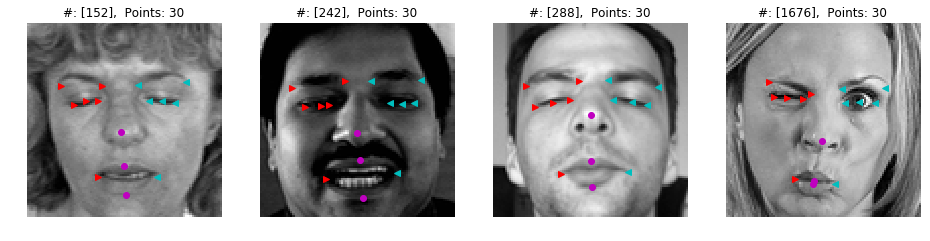

In [6]:
imgs_eyes_closed    = np.array([152, 242, 288, 1676])

print("\nSample images with eyes closed")
plot_img_group( imgs_eyes_closed )


#### Group2:

##### Highly blurred:
Group 2 had much higher share of images that were highly blurred out to provide any significant feature extractions. Some of these may not have been useful for training the model at all, and were dropped from the final training dataset. 


Sample images that are highly blurred


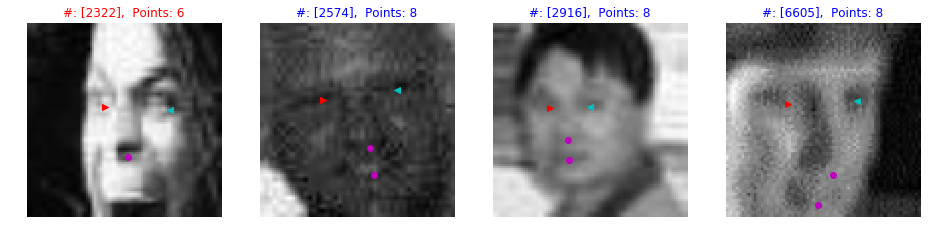

In [7]:
imgs_high_blur    = np.array([2322, 2574, 2916, 6605])

print("\nSample images that are highly blurred")
plot_img_group( imgs_high_blur )

#### Common to both groups:

##### Partially/fully covered keypoints:
These images had section around the eyes partially covered with hairs, hat etc. or some other facial features obstructed by various objects, props, sunglasses or the face was partially placed in dark shadow. These again had approximations of these obscured keypoints. The question was whether these obscured features would provide any real benefit to the model for feature extraction or not. Most of these were finally left in the dataset, as atleast the unobstructed keypoints will serve just fine for training the models. 

##### A second partial/full face:
Some images had more than one face either partially or fully appearing in the foreground/background. Although some of these were labelled correctly, we assumed this could probably mislead the model, especially in cases where more than one face is prominent. Some of these in which the primary face was not sufficiently prominent, were dropped from the training dataset.

##### Wrong/bad labels:
These images outright have wrong or bad labelling and were removed from the train dataset. 

##### Missing keypoints:
Most of such images e.g. with only 28 or 26 keypoints for group1, and, 6 or 4 keypoints for group2 were either out of frame, or had the face viewed sideways, or were overshadowed and hence were't able to capture/specify all keypoints. Nevertheless, these were quite valid for training, and kept as such.



Sample images with partial or fully covered/obscured keypoints


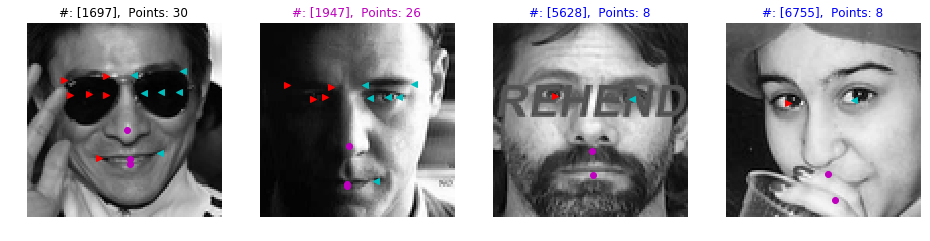


Sample images with a second partial/full face


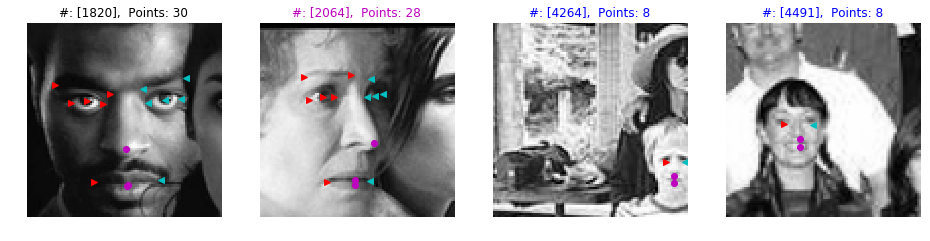


Sample images with bad/wrong labelling


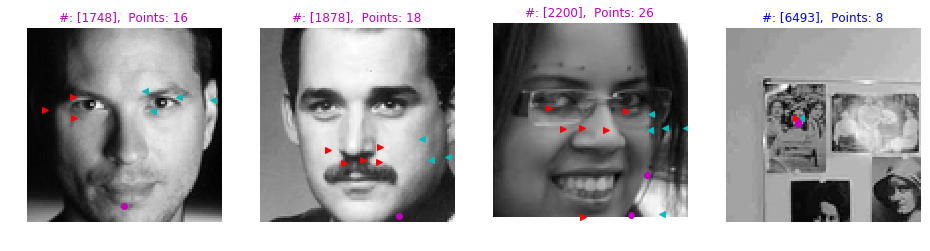


Sample images with missing keypoints


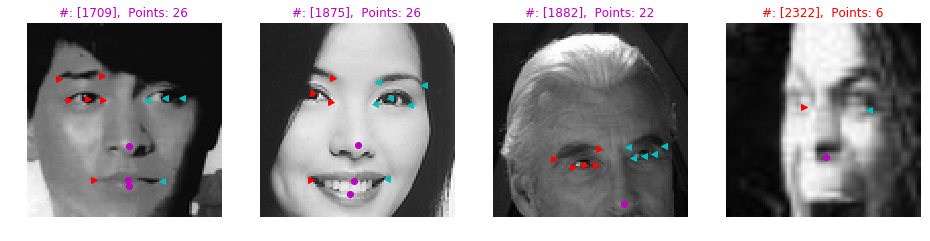

In [8]:
imgs_obstructed     = np.array([1697, 1947, 5628, 6755])
imgs_2nd_face       = np.array([1820, 2064, 4264, 4491])
imgs_bad_labels     = np.array([1748, 1878, 2200, 6493])
imgs_miss_keyps     = np.array([1709, 1875, 1882, 2322])

print("\nSample images with partial or fully covered/obscured keypoints")
plot_img_group( imgs_obstructed )

print("\nSample images with a second partial/full face")
plot_img_group( imgs_2nd_face )

print("\nSample images with bad/wrong labelling")
plot_img_group( imgs_bad_labels )

print("\nSample images with missing keypoints")
plot_img_group( imgs_miss_keyps )

It appears that a different labeling scheme was used for images that had more than 8 keypoints than for those that had 8 or fewer. For example, the 8 or fewer keypoit images mark the tip of the nose as underneath the nose. They also mark the center bottom lip in the center of the mouth, often on the teeth.

Based on these observations, we decided to build 2 separate models, one for group2 images with 8 keypoints, and another for group1 with 30.  

In [9]:
# Final indices of images to be dropped from the dataset

IDX_BAD_IMAGES = np.array( [1621, 1862, 1748, 1878, 1927, 2200, 2431, 2584, 2647, 
                            2671, 2765, 4198, 1627, 1628, 1637, 1957, 4477, 1820, 
                            2064, 2089, 2091, 2109, 2195, 4264, 4491, 6490, 6493, 
                            6494, 1655, 2096, 2454, 3206, 3287, 5628, 5653, 6754, 
                            6755, 2321, 2322, 2414, 2428, 2462, 2574, 2584, 2663, 
                            2691, 2694, 2830, 2910, 2916, 3126, 3176, 3291, 3299, 
                            3361, 4061, 4483, 4484, 4494, 4766, 4809, 4837, 4880, 
                            4905, 5068, 5362, 5566, 5868, 6535, 6538, 6588, 6605, 
                            6659, 6724, 6733, 6753, 6758, 6766, 6907 ] )

### Loading the data
This section loads data for two separate groups. One group has all 30 keypoints and the other contains images that have 8 keypoints. Separate models will be trained on each of these groups because they appeared to have different labeling schemes.

In [10]:
# Function to clean up the train dataset, normalize it, drop bad images & labels, 
# and finally split the dataset into 2, for group1 and group2 modelling.

def loaderV2(test=False, seed=None, keeplabels=None):
    
    if seed:
        np.random.seed(seed)
    fileloc = TEST_DATA if test else TRAIN_DATA
    
    df = read_csv(fileloc)
    
    df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if keeplabels:
        df = df[list(keeplabels) + ['Image']]
        
    X = np.vstack(df['Image'])
    
    if not test:                                       # process train dataset
        Y = df[df.columns.difference(['Image'])].values
        Y = Y.astype(np.float32)
        
        # remove rows having bad images or labels
        X = np.delete( X, (IDX_BAD_IMAGES - 1), axis=0 )
        Y = np.delete( Y, (IDX_BAD_IMAGES - 1), axis=0 )
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.astype(np.float32)
    
        Y = (Y - 48) / 48                     # this helps, but tanh on output doesnt
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, Y = X[shuffle], Y[shuffle]
    
        X = X.reshape(-1, 96, 96, 1)
        
        # split X and Y into dataset for model1 (more than 8 keypoints) and model2 (less than 8 keypoints)
        X_model1 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        X_model2 = np.zeros( (X.shape[0], 96,96,1), dtype=np.float32)
        Y_model1 = np.zeros( Y.shape, dtype=float)
        Y_model2 = np.zeros( Y.shape, dtype=float)
        tempIdx1 = 0
        tempIdx2 = 0
        
        for thisIdx in range(0, Y.shape[0]):
            numKeyps  = NUM_KEYPOINTS - np.isnan(Y[thisIdx]).sum()
            
            if( ( numKeyps > 8 ) ):
                X_model1[tempIdx1] = X[thisIdx,:,:]
                Y_model1[tempIdx1] = Y[thisIdx,:]
                tempIdx1 = tempIdx1 + 1
            else:
                X_model2[tempIdx2] = X[thisIdx,:,:]
                Y_model2[tempIdx2] = Y[thisIdx,:]
                tempIdx2 = tempIdx2 + 1
    
        # remove empty rows
        drop_idx1 = []
        drop_idx2 = []
        
        for idx in range(0, X.shape[0]):
            if( (np.all(Y_model1[idx] == 0)) | (np.isnan(Y_model1[idx]).sum() != 0) ):
                drop_idx1.append(idx)
            if( (np.all(Y_model2[idx] == 0)) | (np.isnan(Y_model2[idx]).sum() != 22) ):
                drop_idx2.append(idx)
        
        X_model1 = np.delete( X_model1, np.array(drop_idx1), axis=0 )
        Y_model1 = np.delete( Y_model1, np.array(drop_idx1), axis=0 )
        X_model2 = np.delete( X_model2, np.array(drop_idx2), axis=0 )
        Y_model2 = np.delete( Y_model2, np.array(drop_idx2), axis=0 )            
        
        # remove empty columns, setup lists of labels
        labels = df.columns.difference(['Image'])
        labels1 = labels
        labels2 = []
        drop_idx3 = []
        for idx in range(0, Y.shape[1]):
            if( (np.all(Y_model2[:,idx] == 0)) | (np.isnan(Y_model2[:,idx]).sum() != 0) ):
                drop_idx3.append(idx)
            else:
                labels2.append(labels[idx])
        Y_model2 = np.delete( Y_model2, np.array(drop_idx3), axis=1 ) 
        
        # return the original dataset and the group splits
        return X_model1, Y_model1, labels1, X_model2, Y_model2, labels2, X, Y, labels
    
    else:                                          # process test dataset
        Y = None
        
        # normalize - by pixel across the whole dataset subtract mean and divide by stdev
        X = X - np.tile(np.mean(X,axis=0),(X.shape[0],1))
        X = X / np.tile(np.std(X,axis=0),(X.shape[0],1))
        X = X.reshape(-1, 96, 96, 1)
        labels = df.columns.difference(['Image'])
        
        return X, Y, labels
    

In [11]:
X1, Y1, labels1,   X2, Y2, labels2,   X, Y, labels = loaderV2(seed=42)

print("Group1 data Y1 shape: ", Y1.shape, ", X1 shape: ", X1.shape)
print("Group2 data Y2 shape: ", Y2.shape, ", X2 shape: ", X2.shape)


Group1 data Y1 shape:  (2137, 30) , X1 shape:  (2137, 96, 96, 1)
Group2 data Y2 shape:  (4697, 8) , X2 shape:  (4697, 96, 96, 1)


## Model Fitting

### Model fitting function
Here we defined a general model fitting function to train each architecture.

In [12]:
def fit_model(model, data, modelname,
              generator=None,retrain=RETRAIN,
              epochs=10000, patience=1000,optimizer=Nadam()):
    # check if the user wants to retrain or if the saved model doesn't exist
    if retrain or not os.path.exists('../saved-models/' + modelname + '.h5'):
        # data setup
        X_train = data[0]
        y_train = data[2]
        if len(data) == 4:
            valid_dat = (data[1], data[3])
        else:
            valid_dat = None

        # default optimization routine to use Nadam and minimize mse
        model.compile(loss='mse', optimizer=optimizer)
        
        # set an early stopping criteria
        if valid_dat:
            earlystop = EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
            
        else:
            earlystop = EarlyStopping(monitor='loss',
                                     patience=patience,
                                     verbose=1,
                                     mode="auto")
        
        callbacks = [earlystop]
        
        # fit the model (with a data generator if present)
        if generator:
            history = model.fit_generator(generator,
                        epochs=epochs,
                        steps_per_epoch=data[0].shape[0]//32,
                        callbacks=callbacks,
                        validation_data=valid_dat
             )
        else:
            history = model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=32,
                                callbacks=callbacks,
                                validation_data=valid_dat,
                                verbose=VERBOSE_TRAIN
                     )
        # save the model weights
        model.save('../saved-models/'+ modelname + '.h5')
        
        # save the model loss history
        with open('../saved-models/histories/'+modelname+'_hist',
                  'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        history = history.history
    
    # if the user doesnt want to retrain, load the weights and model history
    else:
        model = load_model('../saved-models/'+modelname+'.h5')
        history = pickle.load(open( "../saved-models/histories/" + modelname + '_hist',
                                   "rb" ))
        
    return history, model

### Data augmenting function
Keras offers an image data generator class that automatically does transformations to input data images. This helps artifically increase the size of your training data set by adding variance to the training images without distorting their meaning.

However, this generator does not change the labels of the images. In our case, when the image changes, we need the labels to change with it. Therefore, we needed to create a custom subclass of the Keras ImageDataGenerator that not only transformed the images, but also transformed the labels with the images. The generator randomly rotates the images by up to 5 degrees, flips the images horizontally, and translates the images up to 5% of the total height/weight of the image. These transformations are only applied if they will not move the keypoints outside of the image.

For more detail, see the CustImageDataGenerator.py file.

In [13]:
# Generator for the models that predict 30 keypoints
datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X1,Y1,whichlabels=list(labels1), batch_size=32)

# Generator for the models that predict 8 keypoints
g2_datagen = CustImageDataGenerator(
    rotation_range=5. #degrees
     ,horizontal_flip=True
     ,width_shift_range=.05 # percent of image width
     ,height_shift_range=.05 # percent of image height
    ).flow(X2,Y2,whichlabels=list(labels2), batch_size=32)

### Build and train the Group 1 Images' Model (more than 8 and upto 30 keypoints to predict)
If you want to see the model train, pass in retrain=True. BE CAREFUL, this will overwrite the old saved model in the saved-models directory.

In [14]:
g1_model3_new = Sequential()

g1_model3_new.add(Conv2D(32,
                 (6, 6),
                 activation='relu',
                input_shape=INPUT_SHAPE))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(5, 5),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Conv2D(filters=128,
                 kernel_size=(2, 2),
                 activation='relu'))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(MaxPooling2D(pool_size=(2, 2)))

g1_model3_new.add(Flatten())
g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())

g1_model3_new.add(Dense(500, activation = "relu"))
g1_model3_new.add(BatchNormalization())
g1_model3_new.add(Dropout(.3))

g1_model3_new.add(Dense(30))

print(g1_model3_new.summary())
g1_model3_new_hist, g1_model3_new = fit_model(g1_model3_new, [X1, None, Y1],
                                'g1_CNN_aug_addedLayers',datagen,retrain=RETRAIN)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 91, 91, 32)        1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 91, 91, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 41, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 256)       262400    
__________

### Build and train the Group 2 Images' Model (maximum 8 keypoints to predict)
If you want to see the model train, pass in retrain=True. BE CAREFUL, this will overwrite the old saved model in the saved-models directory.

In [15]:
g2_model4 = Sequential()

g2_model4.add(Conv2D(filters=64,
                 kernel_size=(6, 6),
                 strides=1,
                 activation='elu',
                 input_shape=INPUT_SHAPE))
g2_model4.add(BatchNormalization())
g2_model4.add(Dropout(.1))

g2_model4.add(Conv2D(filters=128,
                 kernel_size=(5, 5),
                 strides=1,
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=256,
                 kernel_size=(4, 4),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.2))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(3, 3),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.3))

g2_model4.add(Conv2D(filters=512,
                 kernel_size=(2, 2),
                 activation='elu'))
g2_model4.add(BatchNormalization())
g2_model4.add(MaxPooling2D(pool_size=(2, 2)))
g2_model4.add(Dropout(.4))

g2_model4.add(Flatten())
g2_model4.add(Dense(500, activation = "elu"))
g2_model4.add(BatchNormalization())
g2_model4.add(Dropout(.4))

g2_model4.add(Dense(100, activation = "elu"))
g2_model4.add(BatchNormalization())

g2_model4.add(Dense(8))

print(g2_model4.summary())

g2_model4_hist, g2_model4 = fit_model(g2_model4,[X2, None, Y2],
                                'g2_CNNv2_aug', generator=g2_datagen
                                     ,retrain=RETRAIN, patience=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 91, 91, 64)        2368      
_________________________________________________________________
batch_normalization_8 (Batch (None, 91, 91, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 91, 91, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 128)       204928    
_________________________________________________________________
batch_normalization_9 (Batch (None, 87, 87, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 43, 43, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 43, 43, 128)       0         
__________

## Predicting labels for test data
### Loading the test images

In [16]:
out_images, _ , _ = loaderV2(test=True, seed=None, keeplabels=None)
print(out_images.shape)

(1783, 96, 96, 1)


### Create predictions
Make predictions with both models. g1 predicts all 30 points, g2 predicts 8 points.

In [17]:
g1_prediction = g1_model3_new.predict(out_images)
g2_prediction = g2_model4.predict(out_images)


### Put the predictions into the submission format
#### Add keypoints per test image to be predicted
This is necessary to know which model's predictions to use

In [18]:
# aggregate the number of keypoints needed for each distinct image in test dataset

IdLookupTable = read_csv('../data/IdLookupTable.csv')

rowIDs = np.array(IdLookupTable['RowId'])
# keypoints to be predicted for each imageID
imgs_numKeyps = np.zeros(max(IdLookupTable['ImageId']), dtype=int)

thisImgKeyps = 0
for rowIdx in range(0, rowIDs.shape[0]):
    thisImgID = IdLookupTable.loc[rowIdx,'ImageId']
    imgs_numKeyps[thisImgID - 1] += 1

print("Total test images: {}".format(imgs_numKeyps.shape) )

Total test images: (1783,)


#### Use the appropriate model for predicting each image's keypoints
That is if the test data requests 8 or fewer keypoints use the group 2 model, otherwise use the group 1 model. We tried using mean of the predictions from both models, for common keypoints, as left_eye_center and right_eye_center; but these yielded higher RMSE.

In [19]:
label_locs1 = {}
label_locs2 = {}
for i, label in enumerate(labels1):
    label_locs1[label]=i

for i, label in enumerate(labels2):
    label_locs2[label]=i
    
IdLookupTable['test'] = IdLookupTable['FeatureName'].replace(label_locs1)

thisRowId = 0
modelUsed = np.zeros(IdLookupTable['RowId'].shape[0], dtype=int)

for imgIdx in range(0, imgs_numKeyps.shape[0]):
    
    if( imgs_numKeyps[imgIdx] > 8):
        for keypIdx in range(0, imgs_numKeyps[imgIdx]):
            map_label_idx1 = label_locs1[IdLookupTable.loc[thisRowId, 'FeatureName']]
            IdLookupTable.loc[thisRowId, 'Location'] =  (48*g1_prediction[imgIdx, map_label_idx1]) + 48
            modelUsed[thisRowId] = 1
            thisRowId += 1
    else:
        for keypIdx in range(0, imgs_numKeyps[imgIdx]):
            map_label_idx2 = label_locs2[IdLookupTable.loc[thisRowId, 'FeatureName']]
            IdLookupTable.loc[thisRowId, 'Location'] =  (48*g2_prediction[imgIdx, map_label_idx2]) + 48
            
            modelUsed[thisRowId] = 2
            thisRowId += 1

IdLookupTable['Location'] = (IdLookupTable['Location'].
                             where(IdLookupTable['Location']<=96, 96).
                             where(IdLookupTable['Location']>=0, 0)
                            )
IdLookupTable.head()

,RowId,ImageId,FeatureName,Location,test
0,1,1,left_eye_center_x,66.238445,0
1,2,1,left_eye_center_y,37.892195,1
2,3,1,right_eye_center_x,28.828826,20
3,4,1,right_eye_center_y,36.806757,21
4,5,1,left_eye_inner_corner_x,59.648207,2


#### Create the submission

In [20]:
Submission = IdLookupTable[['RowId','Location']]
Submission.to_csv(path_or_buf='Final_FacialKeypoints.csv',
                  index=False)

## Evaluation
Our final model's predictions submitted to kaggle produce a RMSE error of 1.71947 on the unseen test data labels. This places us 4th on the public Kaggle leaderboard. This is much better than the baseline we set of 3.138 just using the mean value of the labels as our prediction. 

![](img/Score.png)